In [1]:
import sys
sys.path.append("../code/")
from sklearn.metrics import mean_absolute_error
from dataloader import APPLIANCE_ORDER, get_train_test
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

torch.manual_seed(0)
np.random.seed(0)


weight_appliance = {'mw':1, 'dw':1, 'dr':1,'fridge':1, 'hvac':1}

# num_hidden, num_iterations, num_layers, p, num_directions = sys.argv[1:6]

In [5]:
num_folds = 5
fold_num = 0
train, test = get_train_test(2, num_folds=num_folds, fold_num=fold_num)
train_aggregate = train[:, 0, None, :, :] 
test_aggregate = test[:, 0, None, :, :]

In [8]:
train_aggregate

(54, 1, 112, 24)

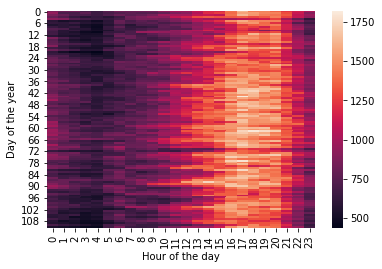

In [58]:
import seaborn as sns
%matplotlib inline
sns.heatmap(pd.DataFrame((train[:, 0, :, :]  - train[:, 1:, :, :].sum(axis=1)).mean(axis=0)))
plt.xlabel("Hour of the day")
plt.ylabel("Day of the year")
plt.savefig("hour-day-residual.pdf",bbox_inches="tight")

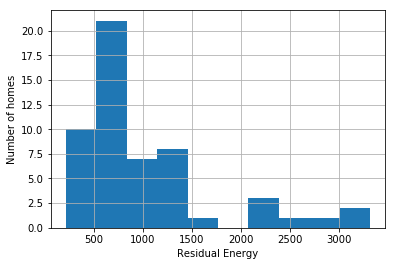

In [59]:
pd.Series((train[:, 0, :, :]  - train[:, 1:, :, :].sum(axis=1)).reshape(54, -1).mean(axis=1)).hist(bins=10)
import matplotlib.pyplot as plt
#pd.Series((100*(train[:, 0, :, :]  - train[:, 1:, :, :].sum(axis=1))/(train[:, 0, :, :]+10.)).reshape(54, -1).mean(axis=1)).hist()
plt.xlabel("Residual Energy")
plt.ylabel("Number of homes")
plt.savefig("residual-energy-dist.pdf",bbox_inches="tight")

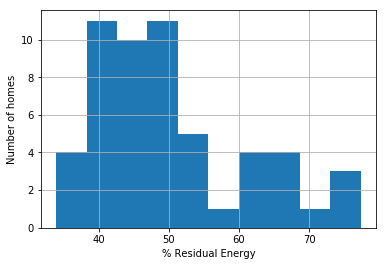

In [60]:
import matplotlib.pyplot as plt
pd.Series((100*(train[:, 0, :, :]  - train[:, 1:, :, :].sum(axis=1))/(train[:, 0, :, :]+10.)).reshape(54, -1).mean(axis=1)).hist()
plt.xlabel("% Residual Energy")
plt.ylabel("Number of homes")
plt.savefig("residual-energy-percentage.pdf",bbox_inches="tight")

In [75]:
(train[:, 0, :, :]  - train[:, 1:, :, :].sum(axis=1)).mean(axis=1)

(54, 24)

In [89]:
x = pd.DataFrame((train[:, 0, :, :]  - train[:, 1:, :, :].sum(axis=1)).mean(axis=1))
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5)

km.fit(x)
y = km.labels_

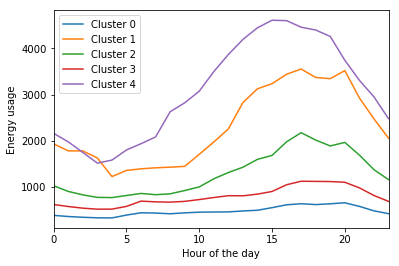

In [98]:
for z in np.unique(y):
    x[y==z].mean().plot(label="Cluster {}".format(z))
plt.legend()
plt.xlabel("Hour of the day")
plt.ylabel("Energy usage")
plt.savefig("residual-cluster.pdf",bbox_inches="tight")

In [296]:
train_appliance = train[:, APPLIANCE_ORDER.index(appliance),None, :, :]
test_appliance = test[:, APPLIANCE_ORDER.index(appliance),None, :, :]

In [297]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.heatmap(train_appliance[5], cmap='Greens')
plt.figure()
sns.heatmap(train_aggregate[5],cmap='Greens')

ValueError: Must pass 2-d input

In [298]:
train_aggregate.shape

(54, 1, 112, 24)

In [299]:
loss_func = nn.L1Loss()
c = CustomCNN()
lr = 0.1
if cuda_av:
    c = c.cuda()
    loss_func = loss_func.cuda()
optimizer = torch.optim.Adam(c.parameters(), lr=lr)

In [300]:
inp = Variable(torch.Tensor(train_aggregate),
               requires_grad=True)
for t in range(num_iterations):
    out = Variable(torch.Tensor(train_appliance))
    if cuda_av:
        inp = inp.cuda()
        out = out.cuda()

    
    pred = c(inp)

    optimizer.zero_grad()
    

    
    loss = loss_func(pred, out)
    if t % 1 == 0:
        print(t, loss.data[0])

    loss.backward()
    optimizer.step()

0 9.197212219238281
1 33.10504150390625
2 19.810867309570312
3 15.607757568359375
4 19.741247177124023
5 14.348755836486816
6 18.1358642578125
7 15.347769737243652
8 9.373226165771484
9 14.317586898803711
10 10.86239242553711
11 10.622010231018066
12 10.808873176574707
13 9.226944923400879
14 11.131441116333008
15 10.164043426513672
16 8.871906280517578
17 9.563580513000488
18 9.569538116455078
19 9.127689361572266
20 8.841306686401367
21 8.924880027770996
22 8.946653366088867
23 9.211385726928711
24 9.187026023864746
25 8.879590034484863
26 8.838238716125488
27 8.723220825195312
28 8.638160705566406
29 8.77259349822998
30 8.881162643432617
31 8.764966011047363
32 8.694026947021484
33 8.64620590209961
34 8.60812759399414
35 8.64212417602539
36 8.652268409729004
37 8.617324829101562
38 8.592608451843262
39 8.596102714538574
40 8.58241081237793
41 8.57442569732666
42 8.580684661865234
43 8.545326232910156
44 8.547028541564941
45 8.55624771118164
46 8.540777206420898
47 8.549107551574707


KeyboardInterrupt: 

In [301]:
train_appliance.shape

(54, 1, 112, 24)

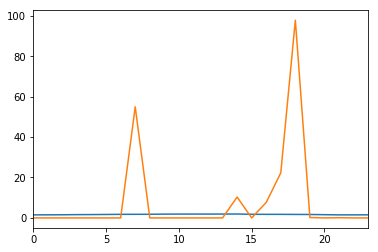

In [302]:
pd.Series(pred[0].data.numpy()[0, 0, :]).plot()
pd.Series(test_appliance[0, 0,0, :]).plot()

In [303]:
test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
test_out = Variable(torch.Tensor(test_appliance), requires_grad=False)


if cuda_av:
    test_inp = test_inp.cuda()
    
    

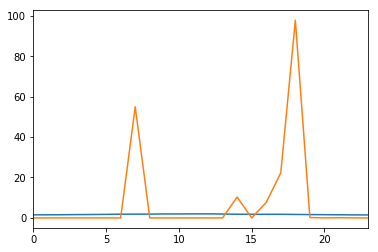

In [304]:
pd.Series(c(test_inp)[0].data.numpy()[0, 0, :]).plot()
pd.Series(test_out.data.numpy()[0, 0, 0, :]).plot()

In [305]:
p = c(test_inp)
p[p<0.] = 0.

In [306]:
loss_func(p, test_out)

Variable containing:
 7.3886
[torch.FloatTensor of size 1]

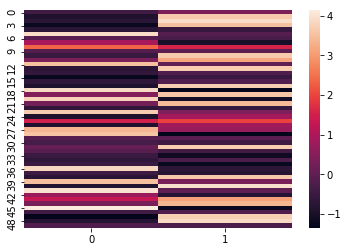

In [174]:
sns.heatmap(pd.DataFrame(list(c.parameters())[0].data.numpy().reshape(50, 2)))

In [ ]:
params = [test_inp, -2]
for i in range(len(ORDER)):
    params.append(None)
pr = a(*params)
pr = torch.clamp(pr, min=0.)
test_pred = torch.split(pr, test_aggregate.shape[0])
prediction_fold = [None for x in range(len(ORDER))]

if cuda_av:
    for appliance_num, appliance in enumerate(ORDER):
        prediction_fold[appliance_num] = test_pred[appliance_num].cpu().data.numpy().reshape(-1, 24)
else:
    for appliance_num, appliance in enumerate(ORDER):
        prediction_fold[appliance_num] = test_pred[appliance_num].data.numpy().reshape(-1, 24)
gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    gt_fold[appliance_num] = test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(test_aggregate.shape[0], -1,
                                                                                         1).reshape(-1, 24)


print([x.mean() for x in pred_split])
error = pd.Series({appliance:mean_absolute_error(gt_fold[appliance_num], prediction_fold[appliance_num]) for appliance_num, appliance in enumerate(ORDER)})